In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

# Configuration matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Librairies importées avec succès")

✅ Librairies importées avec succès


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from os import listdir
import warnings
from tqdm.notebook import tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, Conv2DTranspose,
                                   MaxPooling2D, UpSampling2D, Reshape,
                                   Flatten, BatchNormalization, Dropout,
                                   LeakyReLU, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import array_to_img

import kagglehub
warnings.filterwarnings('ignore')

2025-07-18 09:44:40.372411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752831880.657727      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752831880.742578      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print("📥 Téléchargement du dataset anime...")
splcher_animefacedataset_path = kagglehub.dataset_download('splcher/animefacedataset')
image_path = os.path.join(splcher_animefacedataset_path, 'images')
print(f"Dataset téléchargé: {image_path}")

📥 Téléchargement du dataset anime...
Dataset téléchargé: /kaggle/input/animefacedataset/images


In [5]:
LATENT_DIM = 128  # Plus grand pour les images complexes
EPOCHS = 10
BATCH_SIZE = 32  # Plus petit pour les images 64x64
LEARNING_RATE = 0.001
IMG_SIZE = 64
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)

In [15]:
def load_anime_images(path, image_size=(64, 64), max_images=3000):
    """Charge et préprocess les images anime"""
    print(f"🖼️ Chargement des images depuis {path}...")
    images = []
    
    for i, img_name in enumerate(tqdm(listdir(path))):
        if i >= max_images:
            break
            
        try:
            img_path = os.path.join(path, img_name)
            temp_image = Image.open(img_path)
            temp_image = temp_image.convert('RGB')
            image = temp_image.resize(image_size)
            image = np.asarray(image)
            # Normalisation entre [-1, 1]
            image = (image / 255.0).astype("float32")
            images.append(image)
        except Exception as e:
            continue
    
    return np.asarray(images)
train_images = load_anime_images(image_path, (IMG_SIZE, IMG_SIZE))
print(f"📊 Images chargées: {train_images.shape}")

🖼️ Chargement des images depuis /kaggle/input/animefacedataset/images...


  0%|          | 0/63565 [00:00<?, ?it/s]

📊 Images chargées: (3000, 64, 64, 3)


In [16]:
n_samples, height, width, channels = train_images.shape
X = train_images.reshape(n_samples, -1)  # Flatten chaque image
print(f"✅ Dataset préparé pour PCA:")
print(f"   • Forme des données: {X.shape}")
print(f"   • Nombre d'échantillons: {len(X)}")
print(f"   • Nombre de features: {X.shape[1]}")

✅ Dataset préparé pour PCA:
   • Forme des données: (3000, 12288)
   • Nombre d'échantillons: 3000
   • Nombre de features: 12288


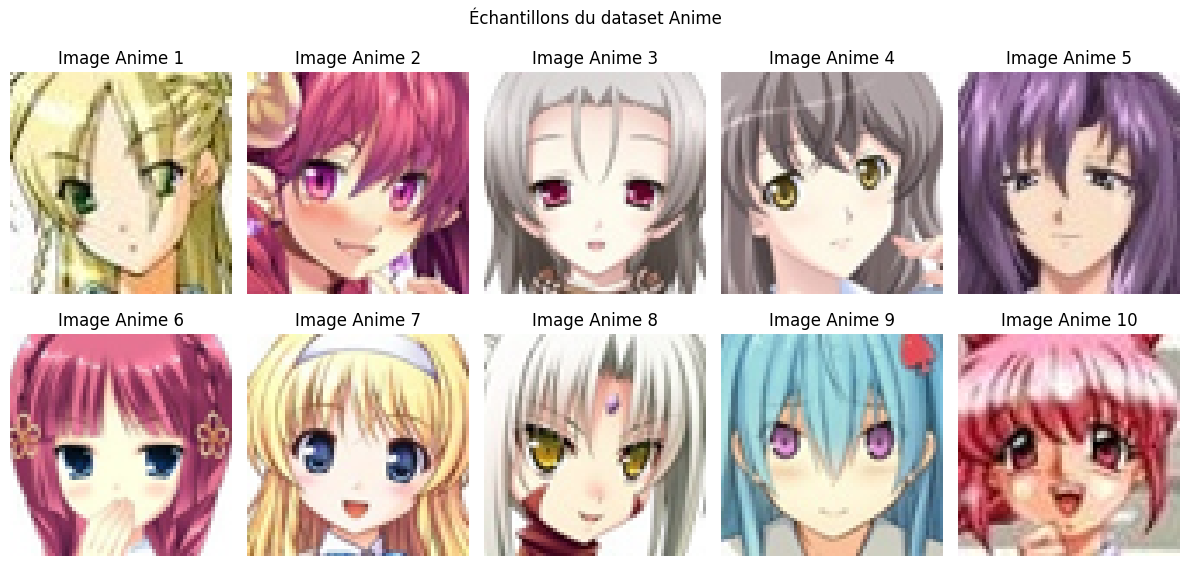

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row, col = i // 5, i % 5
    # Dénormaliser pour affichage: de [-1,1] vers [0,1]
    img_display = (train_images[i] + 1) / 2
    axes[row, col].imshow(img_display)
    axes[row, col].set_title(f'Image Anime {i+1}')
    axes[row, col].axis('off')

plt.suptitle('Échantillons du dataset Anime')
plt.tight_layout()
plt.show()

✅ Dataset chargé:
   • Forme des données: (10000, 784)
   • Nombre d'échantillons: 10000
   • Nombre de features: 784
   • Classes: [0 1 2 3 4 5 6 7 8 9]


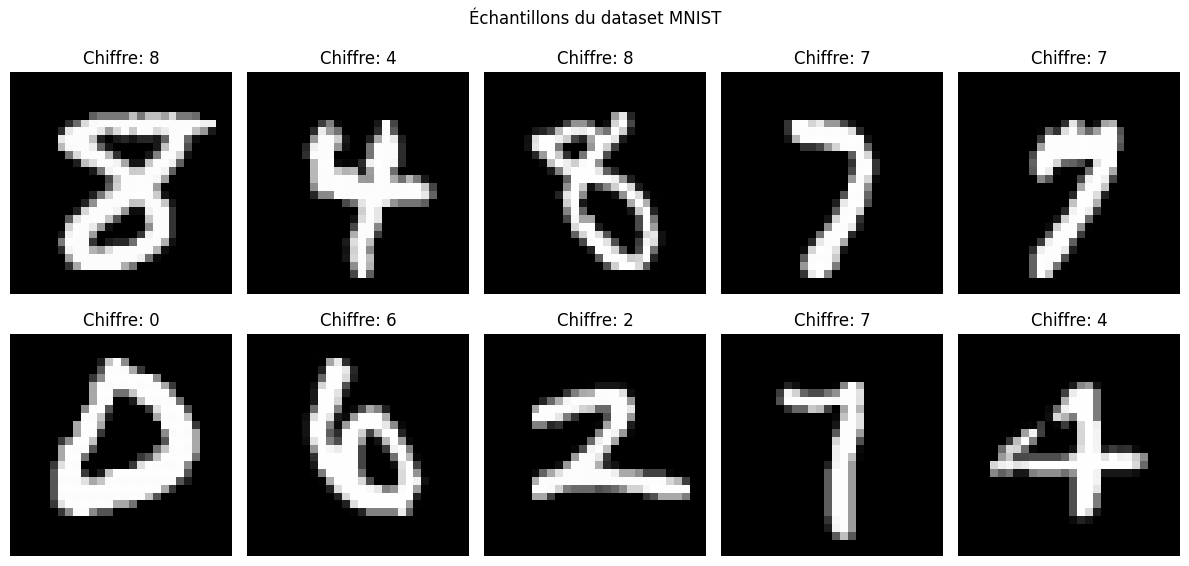

In [ ]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.values, mnist.target.values.astype(int)

n_samples = 10000
np.random.seed(42)
indices = np.random.choice(X.shape[0], n_samples, replace=False)
X = X[indices] / 255.0
y = y[indices]

print(f"✅ Dataset chargé:")
print(f"   • Forme des données: {X.shape}")
print(f"   • Nombre d'échantillons: {len(X)}")
print(f"   • Nombre de features: {X.shape[1]}")
print(f"   • Classes: {np.unique(y)}")

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row, col = i // 5, i % 5
    axes[row, col].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[row, col].set_title(f'Chiffre: {y[i]}')
    axes[row, col].axis('off')

plt.suptitle('Échantillons du dataset MNIST')
plt.tight_layout()
plt.show()

In [18]:
class FullScratchPCA:
    def __init__(self, n_components, max_iter=1000, tol=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.mean = None
        self.components = None
        self.eigenvalues = None
        self.explained_variance_ratio = None

    def center_data(self, X):
        """Centre les données"""
        self.mean = np.mean(X, axis=0)
        return X - self.mean

    def compute_covariance_matrix(self, X_centered):
        """Calcule la matrice de covariance"""
        n_samples = X_centered.shape[0]
        return (1 / (n_samples - 1)) * (X_centered.T @ X_centered)

    def power_iteration(self, A):
        n = A.shape[1]
        v = np.random.rand(n)
        v /= np.linalg.norm(v)

        eigenvalue = 0
        for _ in range(self.max_iter):
            Av = A @ v
            eigenvalue = np.dot(v, Av)
            v_new = Av / np.linalg.norm(Av)
            if np.linalg.norm(v - v_new) < self.tol:
                break
            v = v_new

        return v, eigenvalue

    def deflate_matrix(self, A, v, eigenvalue):
        """Déflation de la matrice"""
        return A - eigenvalue * np.outer(v, v)

    def fit(self, X):
        """Ajuste la PCA aux données"""
        print(f"🔄 Entraînement PCA avec {self.n_components} composantes...")

        X_centered = self.center_data(X)
        cov_matrix = self.compute_covariance_matrix(X_centered)

        A = cov_matrix.copy()
        components = []
        eigenvalues = []

        for i in range(self.n_components):
            if (i + 1) % 10 == 0:
                print(f"   • Composante {i+1}/{self.n_components}")
            v, eigenvalue = self.power_iteration(A)
            components.append(v)
            eigenvalues.append(eigenvalue)
            A = self.deflate_matrix(A, v, eigenvalue)

        self.components = np.array(components).T  # shape (features, n_components)
        self.eigenvalues = np.array(eigenvalues)

        total_variance = np.trace(cov_matrix)
        self.explained_variance_ratio = self.eigenvalues / total_variance

        print(f"✅ PCA entraînée avec succès!")
        print(f"   • Variance expliquée totale: {np.sum(self.explained_variance_ratio):.3f}")

        return self

    def compress(self, X):
        """Compression : projection dans l'espace réduit"""
        if self.components is None:
            raise ValueError("PCA not fitted. Call fit() first.")
        X_centered = X - self.mean
        return X_centered @ self.components

    def decompress(self, X_compressed):
        """Décompression : retour dans l'espace original"""
        if self.components is None:
            raise ValueError("PCA not fitted. Call fit() first.")
        return X_compressed @ self.components.T + self.mean

    def transform(self, X):
        """Alias de compress"""
        return self.compress(X)

    def inverse_transform(self, X_compressed):
        """Alias de decompress"""
        return self.decompress(X_compressed)

print("✅ Classe FullScratchPCA définie")

✅ Classe FullScratchPCA définie


🎯 ÉTAPE 1: Visualisation 2D
🔄 Entraînement PCA avec 10 composantes...
   • Composante 10/10
✅ PCA entraînée avec succès!
   • Variance expliquée totale: 0.493


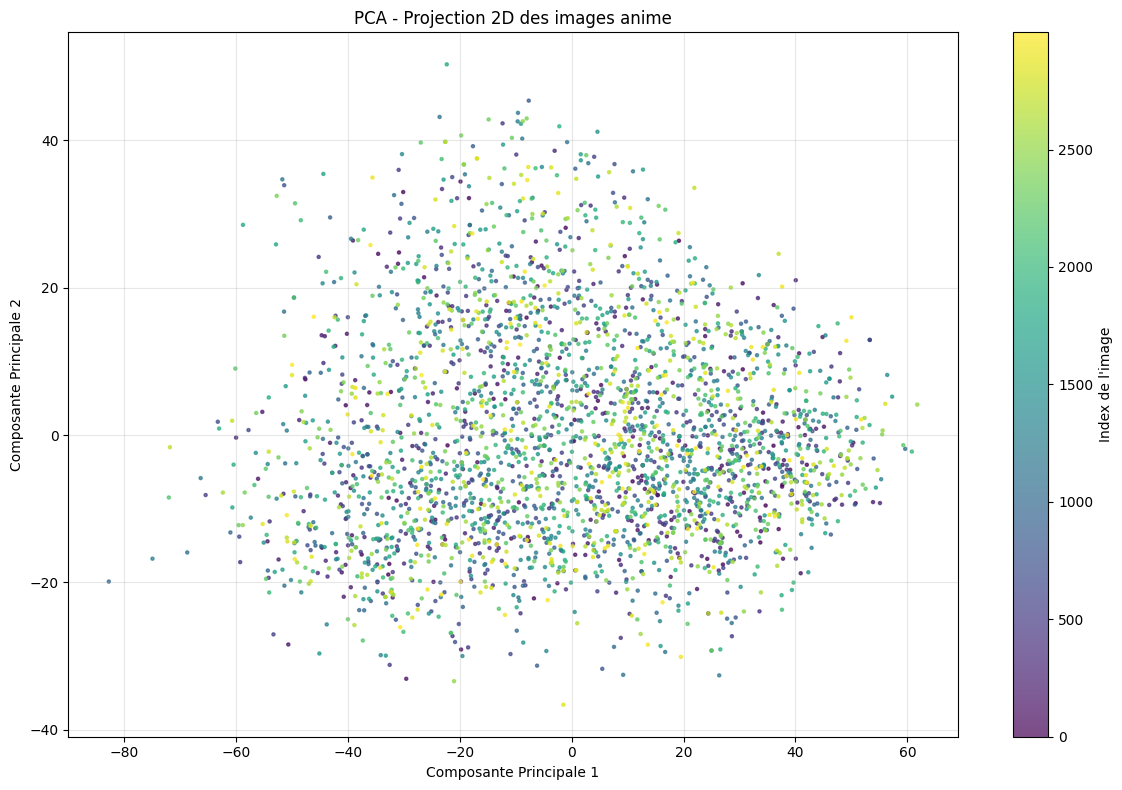

✅ Projection 2D terminée
   • Variance expliquée: 0.493


In [19]:
print("🎯 ÉTAPE 1: Visualisation 2D")
pca2d = FullScratchPCA(n_components=10)
pca2d.fit(X)

X_proj = pca2d.transform(X)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_proj[:, 0], X_proj[:, 1], c=np.arange(len(X_proj)), cmap='viridis', s=5, alpha=0.7)
plt.title("PCA - Projection 2D des images anime")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.colorbar(scatter, label="Index de l'image")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Projection 2D terminée")
print(f"   • Variance expliquée: {np.sum(pca2d.explained_variance_ratio):.3f}")


In [24]:
print("🎯 ÉTAPE 2: Analyse de compression multi-composantes")

components_list = [200]
results = []
reconstructions = []

for n_comp in components_list:
    print(f"\n📊 Test avec {n_comp} composantes...")

    pca = FullScratchPCA(n_components=n_comp)
    pca.fit(X)

    X_compressed = pca.compress(X)
    X_reconstructed = pca.decompress(X_compressed)

    # Calcul des métriques
    mse = np.mean((X - X_reconstructed) ** 2)
    compression_ratio = X.shape[1] / n_comp

    results.append({
        'n_components': n_comp,
        'mse': mse,
        'compression_ratio': compression_ratio,
        'variance_explained': np.sum(pca.explained_variance_ratio)
    })

    # Conserver les 3 premières reconstructions (dénormalisées pour affichage)
    reconstructions.append((X_reconstructed[:3] + 1) / 2)  # De [-1,1] vers [0,1]


🎯 ÉTAPE 2: Analyse de compression multi-composantes

📊 Test avec 200 composantes...
🔄 Entraînement PCA avec 200 composantes...
   • Composante 10/200
   • Composante 20/200
   • Composante 30/200
   • Composante 40/200
   • Composante 50/200
   • Composante 60/200
   • Composante 70/200


KeyboardInterrupt: 

In [ ]:
print("\n🖼️ Comparaison visuelle des reconstructions:")

fig, axes = plt.subplots(len(components_list) + 1, 3, figsize=(10, 2 * (len(components_list) + 1)))

# Images originales
for j in range(3):
    # Dénormaliser pour affichage: de [-1,1] vers [0,1]
    original_img = (train_images[j] + 1) / 2
    axes[0, j].imshow(original_img)
    axes[0, j].set_title(f'Original {j+1}')
    axes[0, j].axis('off')

# Reconstructions
for i, (n_comp, reconstruction) in enumerate(zip(components_list, reconstructions)):
    for j in range(3):
        reconstructed_img = reconstruction[j].reshape(IMG_SIZE, IMG_SIZE, CHANNELS)
        reconstructed_img = np.clip(reconstructed_img, 0, 1)
        axes[i + 1, j].imshow(reconstructed_img)
        axes[i + 1, j].set_title(f'{n_comp} comp.')
        axes[i + 1, j].axis('off')

plt.suptitle('Comparaison visuelle: Original vs Reconstructions PCA')
plt.tight_layout()
plt.show()



In [ ]:
print("🎯 ÉTAPE 3: Génération de variations")

target_indices = [0, 100, 200]  # Indices des images à varier
n_components = 100

pca = FullScratchPCA(n_components=n_components)
pca.fit(X)

for idx, target_idx in enumerate(target_indices):
    if target_idx >= len(X):
        continue
        
    print(f"\n📊 Exemple {idx + 1}: Génération de variations de l'image {target_idx}")

    original_image = X[target_idx]
    print(f"   • Image choisie: index {target_idx}")

    # Comprimer l'image originale
    compressed = pca.compress(original_image.reshape(1, -1))[0]

    # Générer 5 variations
    variations = []
    for i in range(5):
        noise = np.random.normal(0, 0.15, compressed.shape)
        noisy_compressed = compressed + noise

        new_image = pca.decompress(noisy_compressed.reshape(1, -1))[0]
        new_image = np.clip(new_image, -1, 1)
        # Dénormaliser pour affichage: de [-1,1] vers [0,1]
        variations.append((new_image + 1) / 2)

    # Visualisation
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))

    # Image originale (dénormalisée)
    original_display = (original_image.reshape(IMG_SIZE, IMG_SIZE, CHANNELS) + 1) / 2
    axes[0].imshow(original_display)
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Variations
    for i, variation in enumerate(variations):
        variation_img = variation.reshape(IMG_SIZE, IMG_SIZE, CHANNELS)
        variation_img = np.clip(variation_img, 0, 1)
        axes[i + 1].imshow(variation_img)
        axes[i + 1].set_title(f"Variation {i + 1}")
        axes[i + 1].axis('off')

    plt.suptitle(f"Exemple {idx + 1}: Image {target_idx} → 5 variations")
    plt.tight_layout()
    plt.show()